**Preparation**

In [1]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import logging
from tqdm.notebook import tqdm
from fingerspelling_trainer.data.transformations.encode_label import EncodeLabel
from keypoint_extraction_pipeline.schemas.annotation import AnnotationRecord
from keypoint_extraction_pipeline.savers.json_saver import JSONSaver
from fingerspelling_trainer.training.utils.alphabets import Alphabet
import hydra

logging.basicConfig(level=logging.INFO)

In [2]:
# Helpers
def load_annotation(path: Path) -> AnnotationRecord:
    return JSONSaver.load_record(path)
def duration_frames(record: AnnotationRecord) -> int:
    return len(record.frames)
def raw_label(record: AnnotationRecord) -> str:
    return record.metadata.label or ""
def signing_hand(record: AnnotationRecord) -> str:
    return (record.metadata.handness or "").lower()

In [3]:
# Define
DATA_PATH = "/home/gts/projects/lruanova/projects/signamed/data/ASL/transformed/"
splits = ["train", "validation", "test"]

In [4]:
# Load everything
DATA_DIR = Path(DATA_PATH)

with hydra.initialize(version_base="1.3", config_path="../config"):
    cfg = hydra.compose(config_name="config")

ALPHABET: Alphabet = hydra.utils.instantiate(
            cfg.dataset.alphabet
        )

file_lists = {s: sorted((DATA_DIR / s).glob("*.json")) for s in splits}

for s, fl in file_lists.items():
    print(f"{s:<10}: {len(fl):5d} samples – {sum(f.stat().st_size for f in fl)/1e6:.1f} MB")


train     : 50401 muestras – 100318.7 MB
validation:  3115 muestras – 6728.1 MB
test      :  1715 muestras – 3488.1 MB


**Load labels**

In [ ]:
MAX_WORKERS = 32

def load_label_parallel(path):
    try:
        rec = load_annotation(path)
        label = raw_label(rec).upper().strip()
        return {"file": str(path), "label": label}
    except Exception as e:
        logging.error(f"Error procesando {path}: {e}")
        return None  # for filter failures

labels = []
for split, files in file_lists.items():
    results = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(load_label_parallel, f): f for f in files}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Labels {split}"):
            res = future.result()
            if res is not None:
                res["split"] = split
                results.append(res)
    labels.extend(results)

label_df = pd.DataFrame(labels)

Labels train:   0%|          | 0/50401 [00:02<?, ?it/s]

Labels validation:   0%|          | 0/3115 [00:01<?, ?it/s]

Labels test:   0%|          | 0/1715 [00:00<?, ?it/s]

**Save & Load utils**

In [ ]:
# Save
label_df.to_parquet("labels_asl.parquet")

In [5]:
# Load
label_df = pd.read_parquet("labels_asl.parquet")

# Label stats

**Frequency of ONLY ALPHABET symbols**

In [9]:
label_formatter = EncodeLabel(
    alphabet=ALPHABET,
    remove_non_alphabetic=False,
    collapse_repeated=False,
    include_spaces=False,
    validate=False
)

df_sym_processed = label_df.copy()
df_sym_processed['formatted_label'] = df_sym_processed['label'].apply(lambda x: label_formatter._format_label(x))
df_sym_processed['encoded_tokens'] = df_sym_processed['formatted_label'].apply(lambda x: ALPHABET.encode_label(x))
df_sym_processed['symbol_list'] = df_sym_processed['encoded_tokens'].apply(
    lambda tokens: [ALPHABET.NUM_TO_LETTER.get(token, f"UNKNOWN_TOKEN_{token}") for token in tokens]
)
df_exploded_symbols = df_sym_processed[['split', 'symbol_list']].explode('symbol_list')
sym_counts_processed = df_exploded_symbols.dropna(subset=['symbol_list']).groupby(['symbol_list','split']).size().reset_index(name='count')
sym_pivot_processed = sym_counts_processed.pivot(index='symbol_list', columns='split', values='count').fillna(0).astype(int)
sym_pivot_processed['total'] = sym_pivot_processed.sum(axis=1)
sym_pivot_processed['percentage'] = 100 * sym_pivot_processed['total'] / sym_pivot_processed['total'].sum()
sym_pivot_processed = sym_pivot_processed.sort_values('total', ascending=False)

display(sym_pivot_processed)


ERROR:root:Character ' not found in the alphabet


split,test,train,validation,total,percentage
symbol_list,,,,,
A,832,23370,1503,25705,9.800744
E,726,20997,1408,23131,8.819335
O,729,19629,1278,21636,8.249325
S,641,18437,1281,20359,7.762433
I,672,16997,1045,18714,7.135232
T,571,15227,862,16660,6.352087
R,530,14851,798,16179,6.168693
N,402,12904,783,14089,5.371822
D,274,10847,698,11819,4.506322


**Plot for ALPHABET symbols**

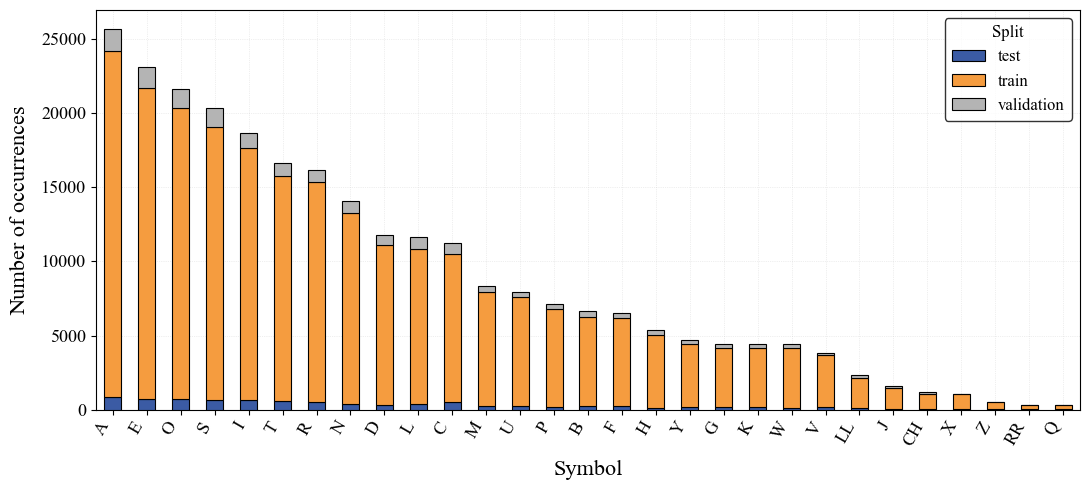

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

font_dir = "/home/gts/projects/lruanova/misc/fonts/times_new_roman"
for f in font_manager.findSystemFonts(fontpaths=font_dir):
    font_manager.fontManager.addfont(f)
mpl.rcParams.update({
    "font.family":  "Times New Roman",
    "pdf.fonttype": 42,
    "ps.fonttype":  42,
})

# Prepare data
df_plot = sym_pivot_processed.copy()
df_plot = df_plot.assign(_total=df_plot.sum(axis=1)) \
                 .sort_values('_total', ascending=False) \
                 .drop(columns='_total')

desired = ['test', 'train', 'validation']
col_map = {c.lower(): c for c in df_plot.columns}
splits  = [col_map[s] for s in desired if s in col_map]
colors = ['#3B5BA4', '#F59C3F', '#B4B4B4'][:len(splits)]
fig, ax = plt.subplots(figsize=(11, 5))
df_plot[splits].plot(kind='bar',
                     stacked=True,
                     ax=ax,
                     color=colors,
                     edgecolor='black',
                     linewidth=0.8,
                     zorder=3)

# Plot format
ax.set_xlabel('Symbol', fontsize=16, labelpad=8)
ax.set_ylabel('Number of occurrences', fontsize=16, labelpad=8)
ax.set_xticklabels(df_plot.index, rotation=60, ha='right', fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(title='Split', fontsize=12, title_fontsize=12,
          loc='upper right', frameon=True, edgecolor='black')
ax.set_axisbelow(True)
ax.grid(axis='both', linestyle=':', linewidth=0.5, alpha=0.4)
fig.tight_layout()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
fig.savefig('sym_stacked_grid.png',
            dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
